In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from PropensityScoreMatching import propension_score_matching
import pandas as pd 
import numpy as np 

### <center> **Création d'un dataframe de test**

In [36]:
data = {'id': [], 'treatment': [], 'CA': [], 'EBE': [], 'annee': []}

for id in range(1000):
    year_of_treatment = np.random.randint(2015, 2020)
    for year in range(2015, 2020):
        data['id'].append(id)
        data['treatment'].append(1 if year == year_of_treatment else 0)
        data['CA'].append(np.random.randn())
        data['EBE'].append(np.random.randn())
        data['annee'].append(year)

for id in range(1001, 3000):
    for year in range(2015, 2020):
        data['id'].append(id)
        data['treatment'].append(0)
        data['CA'].append(np.random.randn())
        data['EBE'].append(np.random.randn())
        data['annee'].append(year)

df = pd.DataFrame(data)

In [37]:
df

,id,treatment,CA,EBE,annee
0,0,0,-1.652591,-0.389673,2015
1,0,0,-1.255420,-1.957612,2016
2,0,1,-0.189584,0.865014,2017
3,0,0,-1.348923,-0.602186,2018
4,0,0,0.063288,-0.593800,2019
...,...,...,...,...,...
14990,2999,0,-1.034823,-0.470300,2015
14991,2999,0,1.105762,0.853634,2016
14992,2999,0,0.532724,-1.308255,2017
14993,2999,0,-1.218605,0.812316,2018


In [42]:
matcher._write_treatment_period(df)

[autoreload of PropensityScoreMatching.propension_score_matching failed: Traceback (most recent call last):
  File "c:\Users\jvincent-galtie-adc\AppData\Local\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\jvincent-galtie-adc\AppData\Local\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 471, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\jvincent-galtie-adc\AppData\Local\anaconda3\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Us

,id,treatment,CA,EBE,annee,annee_treatment,treatment_period,treated_over_time
0,0,0,-1.652591,-0.389673,2015,2017.0,-2.0,1
1,0,0,-1.255420,-1.957612,2016,2017.0,-1.0,1
2,0,1,-0.189584,0.865014,2017,2017.0,0.0,1
3,0,0,-1.348923,-0.602186,2018,2017.0,1.0,1
4,0,0,0.063288,-0.593800,2019,2017.0,2.0,1
...,...,...,...,...,...,...,...,...
14990,2999,0,-1.034823,-0.470300,2015,NaN,NaN,1
14991,2999,0,1.105762,0.853634,2016,NaN,NaN,1
14992,2999,0,0.532724,-1.308255,2017,NaN,NaN,1
14993,2999,0,-1.218605,0.812316,2018,NaN,NaN,1


In [45]:
df["annee" + "_treatment"].apply(lambda x : 1 if not np.isnan(x) else 0)

SyntaxError: expected 'else' after 'if' expression (1408313922.py, line 1)

In [27]:
df

,id,treatment,CA,EBE,annee,propensity_score
0,0,1,0.823459,-0.911218,2015,0.048040
1,0,0,2.017386,-1.298021,2016,0.045868
2,0,0,0.964949,-0.603455,2017,0.047973
3,0,0,-0.642357,-0.258682,2018,0.050945
4,0,0,1.644529,0.358447,2019,0.047368
...,...,...,...,...,...,...
19995,2999,0,0.675325,-0.310597,2015,0.048625
19996,2999,0,-0.870408,1.656860,2016,0.052492
19997,2999,0,-0.403967,-0.220309,2017,0.050545
19998,2999,0,-0.794792,0.518239,2018,0.051675


### <center> **`initialisation du matcher`**

In [38]:
matcher = propension_score_matching.PropensityScoreMatcher(ratio=1, var_treatment="treatment", time_series_var="annee", id_var="id")

NameError: name 'df' is not defined

### <center> **`Fit du Logit`**

In [14]:
df = matcher.fit_logit_on_df(df, ['CA', 'EBE'])

Optimization terminated successfully.
         Current function value: 0.198479
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                20000
Model:                          Logit   Df Residuals:                    19997
Method:                           MLE   Df Model:                            2
Date:                Thu, 28 Mar 2024   Pseudo R-squ.:               0.0001805
Time:                        17:28:38   Log-Likelihood:                -3969.6
converged:                       True   LL-Null:                       -3970.3
Covariance Type:            nonrobust   LLR p-value:                    0.4883
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9452      0.032    -90.711      0.000      -3.009      -2.882
CA            -0.0367      0.

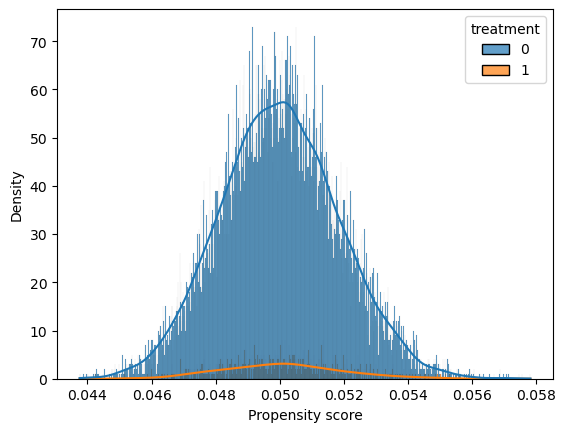

In [15]:
matcher.check_plot_common_support(df)

### <center> **`Matching`**

In [25]:
df_matched = matcher.match(df, exact_matching=[''])

Processing to matching row by row: 100%|██████████| 20000/20000 [00:01<00:00, 12465.94it/s]


In [26]:
df_matched[df_matched]

,id,treatment,CA,EBE,annee,propensity_score,annee_treatment,treatment_period,treated_over_time,matched_index,to_keep_after_matching
0,0,1,0.823459,-0.911218,2015,0.048040,2015.0,0.0,1,[],1.0
1,0,0,2.017386,-1.298021,2016,0.045868,2015.0,1.0,1,NaN,0.0
2,0,0,0.964949,-0.603455,2017,0.047973,2015.0,2.0,1,NaN,0.0
3,0,0,-0.642357,-0.258682,2018,0.050945,2015.0,3.0,1,NaN,0.0
4,0,0,1.644529,0.358447,2019,0.047368,2015.0,4.0,1,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
19995,2999,0,0.675325,-0.310597,2015,0.048625,NaN,NaN,1,NaN,0.0
19996,2999,0,-0.870408,1.656860,2016,0.052492,NaN,NaN,1,NaN,0.0
19997,2999,0,-0.403967,-0.220309,2017,0.050545,NaN,NaN,1,NaN,0.0
19998,2999,0,-0.794792,0.518239,2018,0.051675,NaN,NaN,1,NaN,0.0
